# Porto Seguro's Safe Driver Kaggle Challenge

Nothing ruins the thrill of buying a brand new car more quickly than seeing your new insurance bill. The sting’s even more painful when you know you’re a good driver. It doesn’t seem fair that you have to pay so much if you’ve been cautious on the road for years.

Porto Seguro, one of Brazil’s largest auto and homeowner insurance companies, completely agrees. Inaccuracies in car insurance company’s claim predictions raise the cost of insurance for good drivers and reduce the price for bad ones.

In this competition, you’re challenged to build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year. While Porto Seguro has used machine learning for the past 20 years, they’re looking to Kaggle’s machine learning community to explore new, more powerful methods. A more accurate prediction will allow them to further tailor their prices, and hopefully make auto insurance coverage more accessible to more drivers.

### Initialize

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import missingno as msno

In [2]:
import gc #garbage collector to free up memory

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from utils import plot

In [5]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')

In [199]:
pd.options.display.float_format = '{:.3f}'.format

In [198]:
rc = {
    'savefig.dpi': 75,
    'figure.autolayout': False,
    'figure.figsize': [12, 8],
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'font.size': 18,
    'lines.linewidth': 2.0,
    'lines.markersize': 8,
    'legend.fontsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16
}

sns.set(style='dark',rc=rc)

In [8]:
default_color = '#55A3E8'
colormap = plt.cm.cool

In [9]:
# Setting working directory

path = './data/raw/'

### Data Description

In this competition, you will predict the probability that an auto insurance policy holder files a claim.

In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.

- train.csv contains the training data, where each row corresponds to a policy holder, and the target columns signifies that a claim was filed.
- test.csv contains the test data.
- sample_submission.csv is submission file showing the correct format.

Suffix info:
- "ind" is related to individual or driver
- "reg" is related to region
- "car" is related to car itself
- "calc" is an calculated feature

Success metric is Gini:
```
GINI = 2 * AOC + 1
```

In [10]:
from sklearn.metrics import roc_auc_score

In [11]:
print(roc_auc_score.__doc__)

Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC)
    from prediction scores.

    Note: this implementation is restricted to the binary classification task
    or multilabel classification task in label indicator format.

    Read more in the :ref:`User Guide <roc_metrics>`.

    Parameters
    ----------
    y_true : array, shape = [n_samples] or [n_samples, n_classes]
        True binary labels in binary label indicators.

    y_score : array, shape = [n_samples] or [n_samples, n_classes]
        Target scores, can either be probability estimates of the positive
        class, confidence values, or non-thresholded measure of decisions
        (as returned by "decision_function" on some classifiers).

    average : string, [None, 'micro', 'macro' (default), 'samples', 'weighted']
        If ``None``, the scores for each class are returned. Otherwise,
        this determines the type of averaging performed on the data:

        ``'micro'``:
            Calculate

## Load Files

In [12]:
train = pd.read_csv(path + 'train.csv', na_values = -1)
test = pd.read_csv(path + 'test.csv', na_values = -1)

In [13]:
train.shape

(595212, 59)

In [14]:
test.shape

(892816, 58)

In [15]:
# keeping ids for future reference
id_test = test['id'].values

## Target Analysis

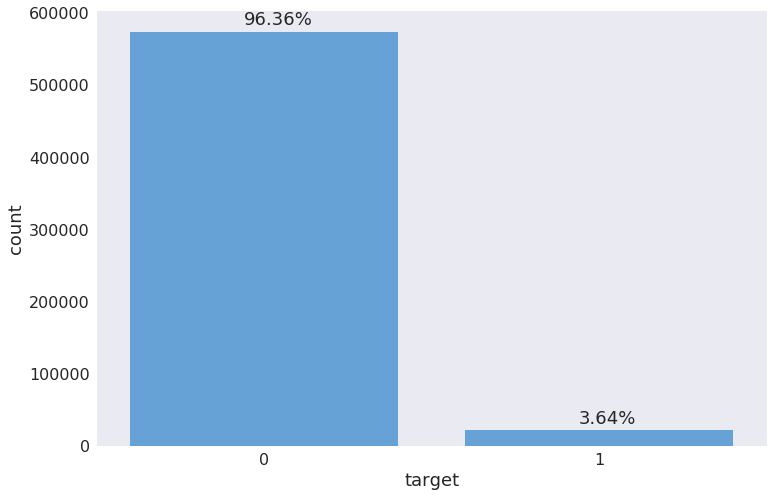

In [20]:
#plt.figure(figsize=(15,5))

ax = sns.countplot('target',data=train,color=default_color)
for patch in ax.patches:
    ax.annotate(
        '{:.2f}%'.format(100 * patch.get_height() / len(train['target'])),
        (patch.get_x() + 0.34, patch.get_height() + 10000))

## Data Pre-Cleaning

In [32]:
# Remove redundant prefixes
train.columns = [ c if 'ps_' not in c else c.replace('ps_', '') for c in train.columns ]
test.columns = [ c if 'ps_' not in c else c.replace('ps_', '') for c in test.columns ]

In [127]:
train.columns[-5:]

Index(['calc_16_bin', 'calc_17_bin', 'calc_18_bin', 'calc_19_bin',
       'calc_20_bin'],
      dtype='object')

## Data analisys

In [150]:
def get_meta(df,
             special = {'id': {'role': 'id', 'level': 'nominal'},
                        'target': {'role': 'target', 'level': 'binary'}},
             suffix_level = {'bin': 'binary', 'cat': 'nominal'},
             dtype_level = {'float64': 'interval', 'int64': 'ordinal'}):
    data = []
    
    for col in df.columns:
        dtype = df[col].dtype
        
        if col in special.keys():
            role = special[col].get('role', None)
            level = special[col].get('level', None)
        else:
            role = 'input'
            level = None

        if not level:
            for suffix in suffix_level.keys():
                if suffix in col:
                    level = suffix_level[suffix]
        
        if not level:
            level = dtype_level.get(str(dtype), None)
        
        # Initialize keep to True for all variables except for id
        keep = False if col == special['id']['role'] else True
        
        col_dict = {
            'varname': col,
            'role': role,
            'level': level,
            'keep': keep,
            'dtype': dtype
        }
        
        data.append(col_dict)
    
    meta = pd.DataFrame(data, columns = ['varname', 'role', 'level', 'keep', 'dtype'])
    meta.set_index('varname', inplace = True)
    
    return meta

In [176]:
special = {'id': {'role': 'id', 'level': 'nominal'}, 'target': {'role': 'target', 'level': 'binary'}}
suffix_level = {'bin': 'binary', 'cat': 'nominal'}
dtype_level = {'float64': 'interval', 'int64': 'ordinal'}

In [177]:
meta_data = get_meta(train, special, suffix_level, dtype_level)
meta_data

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ind_01,input,ordinal,True,int64
ind_02_cat,input,nominal,True,float64
ind_03,input,ordinal,True,int64
ind_04_cat,input,nominal,True,float64
ind_05_cat,input,nominal,True,float64
ind_06_bin,input,binary,True,int64
ind_07_bin,input,binary,True,int64


In [186]:
# meta_data.groupby(by=['role', 'level']).agg({'dtype': lambda x: x.count()}).reset_index()
meta_counts = meta_data.pivot_table(values='dtype', index=['role', 'level'], aggfunc=lambda x: x.count()).reset_index()
meta_counts

,role,level,dtype
0,id,nominal,1
1,input,binary,17
2,input,interval,11
3,input,nominal,14
4,input,ordinal,15
5,target,binary,1


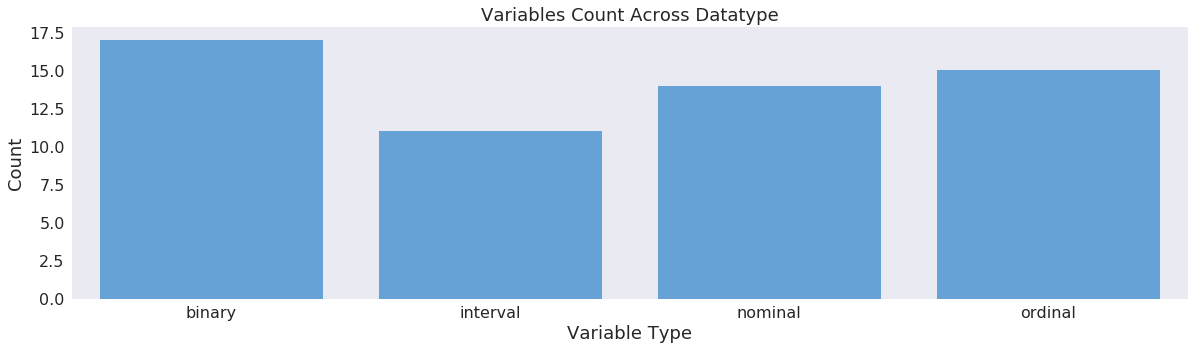

In [189]:
fig,ax = plt.subplots()
fig.set_size_inches(20,5)

sns.barplot(data = meta_counts[~meta_counts.role.isin( ['target', 'id'])],
            x = 'level',y = 'dtype',
            ax = ax,
            color = default_color)

ax.set(xlabel = 'Variable Type', ylabel = 'Count', title = "Variables Count Across Datatype")

In [190]:
col_ordinal   = meta_data[(meta_data.level == 'ordinal') & (meta_data.keep)].index
col_nominal   = meta_data[(meta_data.level == 'nominal') & (meta_data.keep)].index
col_internval = meta_data[(meta_data.level == 'interval') & (meta_data.keep)].index
col_binary    = meta_data[(meta_data.level == 'binary') & (meta_data.keep) & (meta_data.role != 'target')].index

### Missing Values

In [191]:
missing_value_cols = train.columns[train.isnull().any()].tolist()
df_null = train[missing_value_cols]

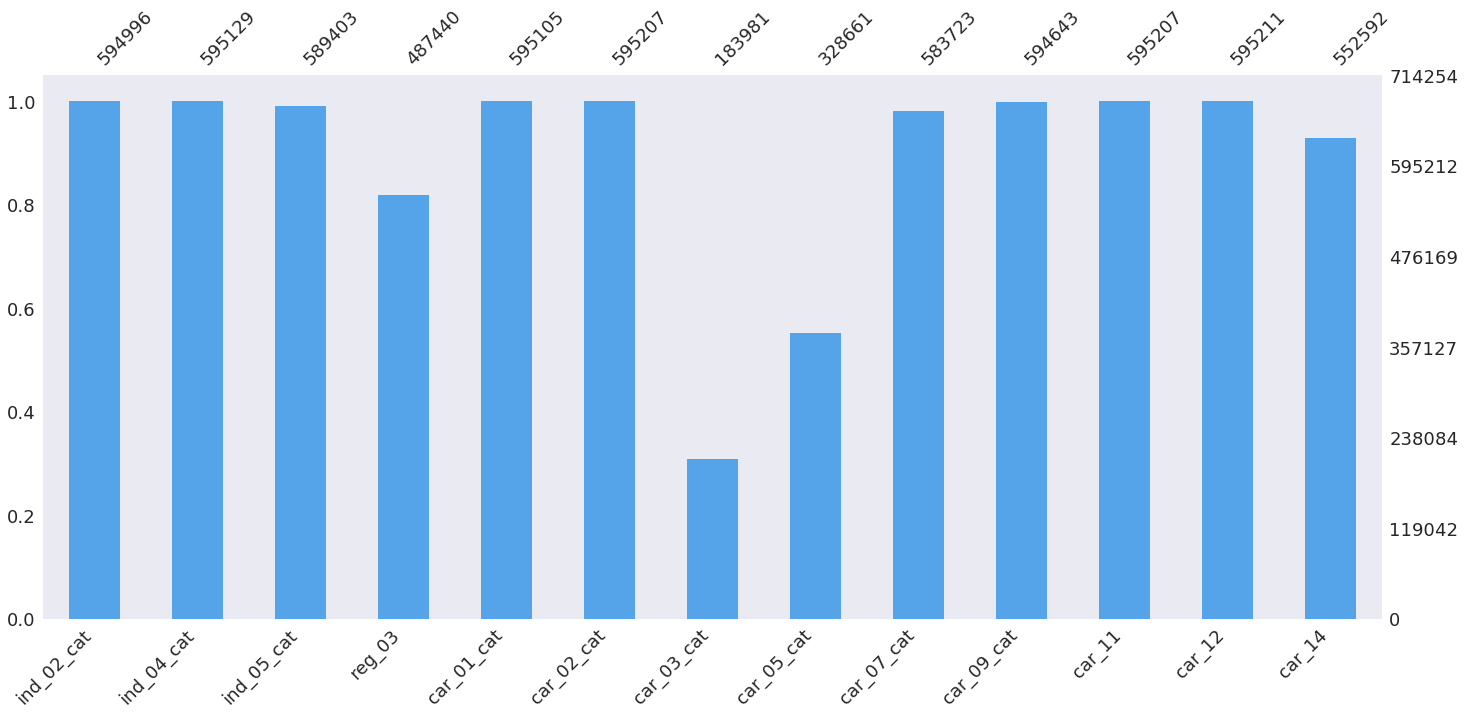

In [192]:
msno.bar(df_null, color = default_color, fontsize = 18, labels = True)

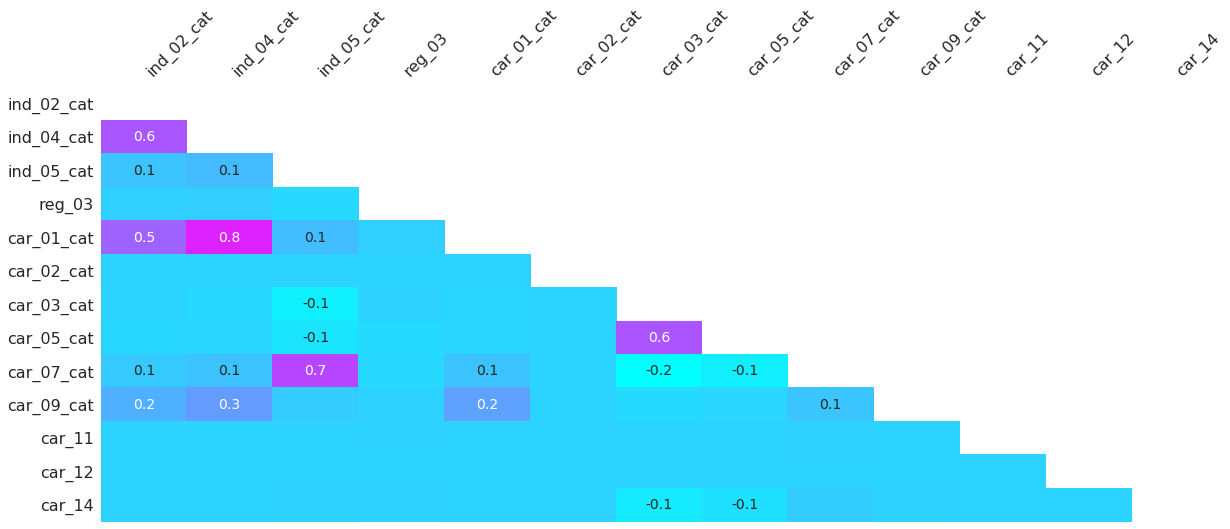

In [193]:
# Correlations between missing values
msno.heatmap(df_null, figsize = (20,8), cmap = colormap)

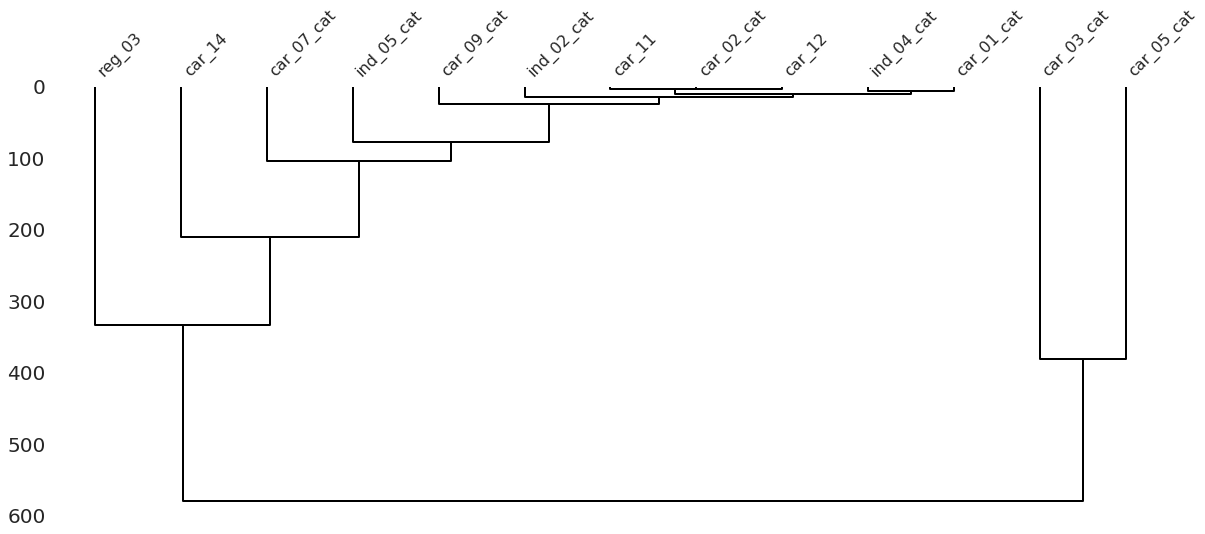

In [194]:
msno.dendrogram(df_null, figsize = (20,8))

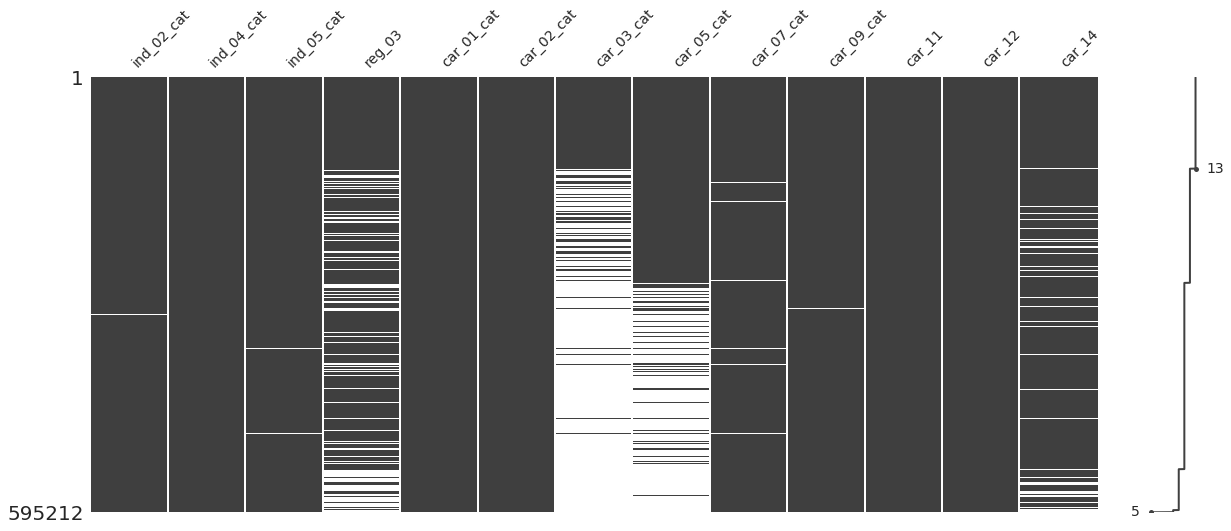

In [195]:
sorted_data = msno.nullity_sort(df_null, sort = 'descending') # or sort='ascending'
msno.matrix(sorted_data, figsize=(20,8), fontsize=14)

## Continuous Features Analisys

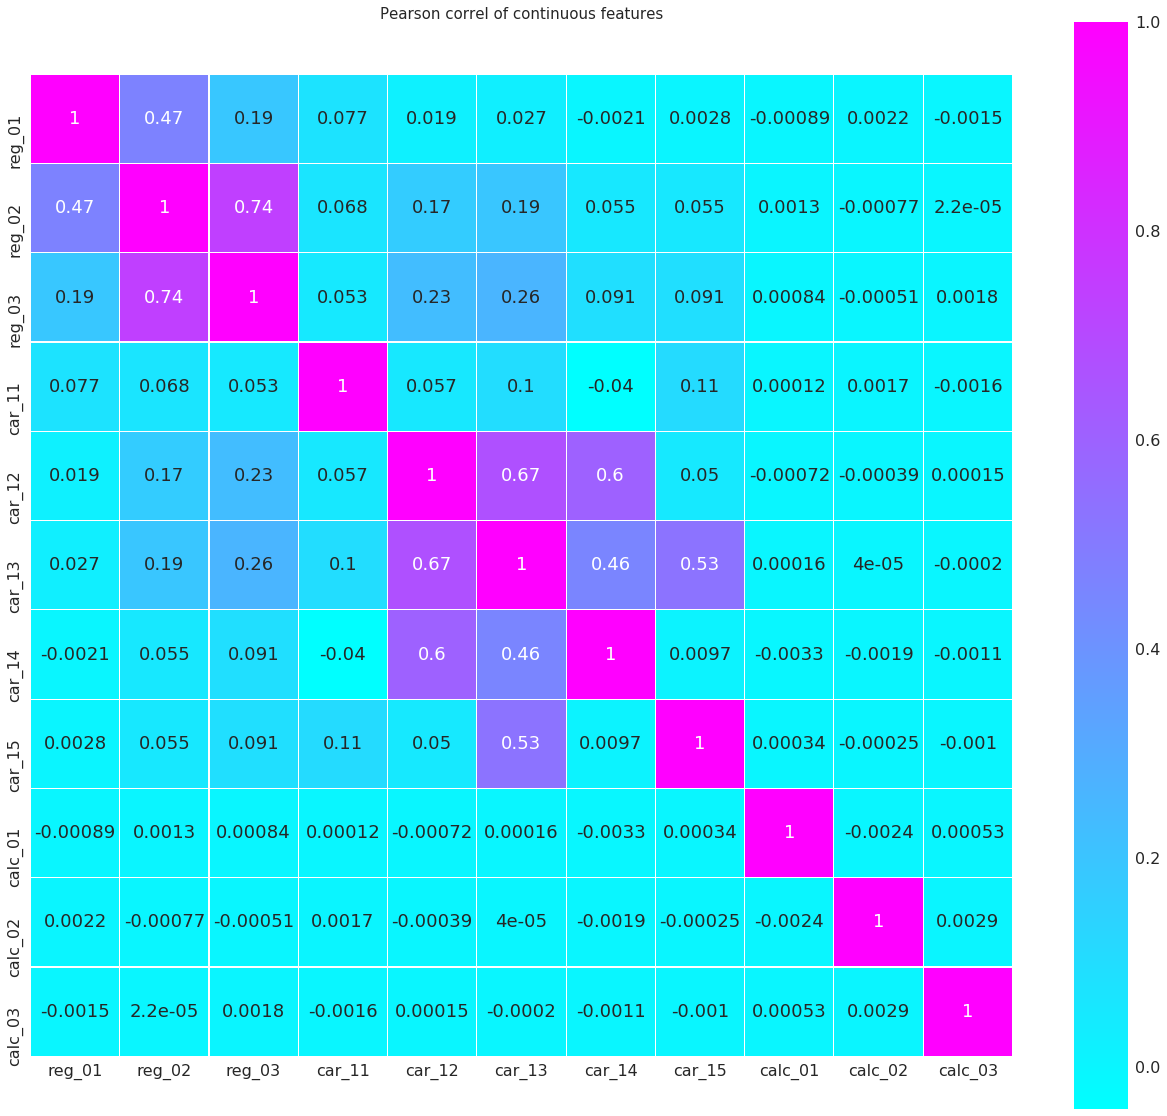

In [202]:
plt.figure(figsize=(22,20))
plt.title('Pearson correl of continuous features', y = 1.05, size = 15)
sns.heatmap(train[col_internval].corr(), linewidths = 0.1, vmax = 1.0, square = True, cmap = colormap, linecolor = 'white', annot = True)